In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders
# splitfolders.ratio("D:\\Stroke Data", output="D:\\Stroke Data_Splitted\\",seed=1337, ratio=(.7, .3), group_prefix=None, move=False)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, Layer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
# Import necessary libraries

import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your CSV files in Google Drive
# Make sure to provide the correct file paths. You can find these paths by navigating
# to the file in your Google Drive, right-clicking, and selecting "Get link."
# Replace 'YourFolder' with the appropriate folder name if your files are inside a folder.
base_path = '/content/drive/My Drive/ColabNotebooks/Cricket_Enhancement/'  # Adjust as needed

# Load your datasets
Straight_Drive_df = pd.read_csv(base_path + "Straight_Drive.csv")
Sweep_df = pd.read_csv(base_path + "Sweep.csv")
Pull_df = pd.read_csv(base_path + "Pull.csv")
onDrive_df = pd.read_csv(base_path + "onDrive.csv")
Flick_df = pd.read_csv(base_path + "Flick.csv")
Cut_df = pd.read_csv(base_path + "Cut.csv")
Cover_Drive_df = pd.read_csv(base_path + "Cover_Drive.csv")
back_foot_punch_df = pd.read_csv(base_path + "back_foot_punch.csv")

# Now you can work with your DataFrames
#print(Straight_Drive_df.head())

MessageError: Error: credential propagation was unsuccessful

In [ ]:
'''
# Suppress warnings
warnings.filterwarnings('ignore')
# Load your datasets
Straight_Drive_df = pd.read_csv("Straight_Drive.csv")
Sweep_df = pd.read_csv("Sweep.csv")
Pull_df = pd.read_csv("Pull.csv")
onDrive_df = pd.read_csv("onDrive.csv")
Flick_df = pd.read_csv("Flick.csv")
Cut_df = pd.read_csv("Cut.csv")
Cover_Drive_df = pd.read_csv("Cover_Drive.csv")
back_foot_punch_df = pd.read_csv("back_foot_punch.csv")
'''

'\n# Suppress warnings\nwarnings.filterwarnings(\'ignore\')\n# Load your datasets\nStraight_Drive_df = pd.read_csv("Straight_Drive.csv")\nSweep_df = pd.read_csv("Sweep.csv")\nPull_df = pd.read_csv("Pull.csv")\nonDrive_df = pd.read_csv("onDrive.csv")\nFlick_df = pd.read_csv("Flick.csv")\nCut_df = pd.read_csv("Cut.csv")\nCover_Drive_df = pd.read_csv("Cover_Drive.csv")\nback_foot_punch_df = pd.read_csv("back_foot_punch.csv")\n'

In [3]:
# List of dataframes
dataframes = [
    Straight_Drive_df, Sweep_df, Pull_df, onDrive_df, Flick_df,
    Cut_df, Cover_Drive_df, back_foot_punch_df
]
# Optional: List of names to identify each dataframe
names = [
    "Straight_Drive", "Sweep", "Pull", "onDrive", "Flick",
    "Cut", "Cover_Drive", "back_foot_punch"
]


NameError: name 'Straight_Drive_df' is not defined

In [2]:
# Loop through each dataframe
for i, df in enumerate(dataframes):
    #print(f"\nFirst 3 rows of {names[i]}:")
    Posdataset=df
    stroke=names[i]
    # Drop unnecessary columns if they exist in each dataframe
    if 'Unnamed: 0' in df.columns and 'Label' in df.columns:
        Posdataset_numeric = df.drop(columns=['Unnamed: 0', 'Label'], axis=1)
    else:
        Posdataset_numeric = df  # If no unnecessary columns to drop

    # Display the first 3 rows
    #print(Posdataset_numeric.head(3))
    print(stroke)


    # Parameters
    timesteps = 10  # Number of previous frames to use for prediction
    n_features = Posdataset_numeric.shape[1]  # Number of features
    train_size = len(Posdataset_numeric) - 11  # Train on first frames
    test_size = 11  # Test on the next frames

    # Split the data into train and test sets
    train_data = Posdataset_numeric.iloc[:train_size].values
    test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

    # Scale the data
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Function to create sequences
    def create_sequences(data, timesteps):
        X, y = [], []
        for i in range(len(data) - timesteps):
            X.append(data[i:i + timesteps])
            y.append(data[i + timesteps])
        return np.array(X), np.array(y)

    # Create sequences
    X_train, y_train = create_sequences(train_data_scaled, timesteps)
    X_test, y_test = create_sequences(test_data_scaled, timesteps)

    # Reshape y_train and y_test to include the time dimension
    y_train = y_train.reshape(y_train.shape[0], n_features)  # Adjusted to 2D
    y_test = y_test.reshape(y_test.shape[0], n_features)  # Adjusted to 2D

    # Custom layer for global average pooling
    class GlobalAveragePooling(Layer):
        def call(self, inputs):
            return tf.reduce_mean(inputs, axis=1)  # Average over timesteps

    # Optimized LSTM Model
    def build_lstm_model():
        model = Sequential()
        model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
        model.add(BatchNormalization())  # Add batch normalization
        model.add(Dropout(0.3))  # Increased dropout for regularization
        model.add(Dense(n_features, kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Add L2 regularization
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Tuned learning rate
        return model



    # Function to create and train Transformer model
    def build_transformer_model():
        input_layer = Input(shape=(timesteps, n_features))
        attention_output = MultiHeadAttention(num_heads=8, key_dim=n_features)(input_layer, input_layer)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
        transformer_output = Dense(64, activation='relu')(attention_output)
        transformer_output = Dropout(0.2)(transformer_output)
        # Use the custom global average pooling layer
        pooled_output = GlobalAveragePooling()(transformer_output)
        output = Dense(n_features)(pooled_output)

        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer='adam', loss='mse')
        return model


    # Function to evaluate the model
    def evaluate_model(model, X_test, y_test):
        predictions = model.predict(X_test)

        # Ensure that predictions and y_test are 2D (samples, features)
        predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
        y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

        # Inverse transform the predictions and y_test
        predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
        y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

        mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
        mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

        return mse, mae, predictions_rescaled, y_test_rescaled

    # Train and evaluate LSTM
    #lstm_model = build_lstm_model()
    #lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    #lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

    # Early Stopping and Learning Rate Scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train and evaluate the LSTM model
    lstm_model = build_lstm_model()
    lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),  callbacks=[early_stopping, reduce_lr], verbose=0)
    lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

    # Output results for LSTM
    print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')

    # Train and evaluate Transformer
    transformer_model = build_transformer_model()
    transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    transformer_mse, transformer_mae, transformer_predictions, transformer_y_test = evaluate_model(transformer_model, X_test, y_test)

    # Output results for Transformer
    print(f'Transformer Model MSE: {transformer_mse}, MAE: {transformer_mae}')

    # Predict the next frame for both models
    # Correctly reshape the input for the LSTM model
    next_frame_lstm = lstm_model.predict(np.reshape(X_test[-1], (1, timesteps, n_features)))
    next_frame_transformer = transformer_model.predict(np.reshape(X_test[-1], (1, timesteps, n_features)))

    # Inverse scale the predictions
    next_frame_lstm_rescaled = scaler.inverse_transform(next_frame_lstm)
    next_frame_transformer_rescaled = scaler.inverse_transform(next_frame_transformer)

    def qualitative_quantitative_diff1(predictions_rescaled, y_test_rescaled, model_name):

        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

        # Assuming predictions_rescaled and y_test_rescaled are numpy arrays with shapes (1,132) and (1,32)
        # Reshape the arrays to be one-dimensional for better comparison
        predictions_rescaled_flat = np.ravel(predictions_rescaled)
        y_test_rescaled_flat = np.ravel(y_test_rescaled)

        # Ensure the two arrays are of the same length by truncating if necessary
        min_length = min(len(predictions_rescaled_flat), len(y_test_rescaled_flat))
        predictions_rescaled_flat = predictions_rescaled_flat[:min_length]
        y_test_rescaled_flat = y_test_rescaled_flat[:min_length]

        # Quantitative metrics
        mse = mean_squared_error(y_test_rescaled_flat, predictions_rescaled_flat)
        mae = mean_absolute_error(y_test_rescaled_flat, predictions_rescaled_flat)
        r2 = r2_score(y_test_rescaled_flat, predictions_rescaled_flat)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R²): {r2}")

        # Visual comparison: Plot actual vs. predicted values
        plt.figure(figsize=(10,6))
        plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', marker='o')
        plt.plot(predictions_rescaled_flat, label='Predicted Values', color='red', linestyle='--', marker='x')
        plt.title('Comparison of Actual and ' + model_name + '  Predicted Values' + " for " + stroke)
        plt.xlabel('Sample Index')
        plt.ylabel('Rescaled Values')
        plt.legend()
        plt.grid(True)
        plt.show()

    def qualitative_quantitative_diff(predictions_rescaled, y_test_rescaled, model_name): #, stroke):
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

        # Assuming predictions_rescaled and y_test_rescaled are numpy arrays
        # Reshape the arrays to be one-dimensional for better comparison
        predictions_rescaled_flat = np.ravel(predictions_rescaled)
        y_test_rescaled_flat = np.ravel(y_test_rescaled)

        # Ensure the two arrays are of the same length by truncating if necessary
        min_length = min(len(predictions_rescaled_flat), len(y_test_rescaled_flat))
        predictions_rescaled_flat = predictions_rescaled_flat[:min_length]
        y_test_rescaled_flat = y_test_rescaled_flat[:min_length]

        # Define the x-axis labels
        x_labels = [  "Nose_x", "Nose_y", "Nose_z", " ", "LEyeInner_x", "LEyeInner_y", "LEyeInner_z", " ",
            "LEye_x", "LEye_y", "LEye_z", " ", "LEyeOuter_x", "LEyeOuter_y", "LEyeOuter_z", " ",
            "REyeInner_x", "REyeInner_y", "REyeInner_z", " ", "REye_x", "REye_y", "REye_z", " ",
            "REyeOuter_x", "REyeOuter_y", "REyeOuter_z", " ", "LEar_x", "LEar_y", "LEar_z", " ",
            "REar_x", "REar_y", "REar_z", " ", "LMouth_x", "LMouth_y", "LMouth_z", " ",
            "RMouth_x", "RMouth_y", "RMouth_z", " ", "LShoulder_x", "LShoulder_y", "LShoulder_z", " ",
            "RShoulder_x", "RShoulder_y", "RShoulder_z", " ", "LElbow_x", "LElbow_y", "LElbow_z", " ",
            "RElbow_x", "RElbow_y", "RElbow_z", " ", "LWrist_x", "LWrist_y", "LWrist_z", " ",
            "RWrist_x", "RWrist_y", "RWrist_z", " ", "LPinky_x", "LPinky_y", "LPinky_z", " ",
            "RPinky_x", "RPinky_y", "RPinky_z", " ",    "LIndex_x", "LIndex_y", "LIndex_z", " ",
            "RIndex_x", "RIndex_y", "RIndex_z", " ",    "LThumb_x", "LThumb _y", "LThumb _z", " ",
            "RThumb_x", "RThumb _y", "RThumb _z", " ",    "LHip_x", "LHip_y", "LHip_z", " ",
            "RHip_x", "RHip_y", "RHip_z", " ", "LKnee_x", "LKnee_y", "LKnee_z", " ",
            "RKnee_x", "RKnee_y", "RKnee_z", " ", "LAnkle_x", "LAnkle_y", "LAnkle_z", " ",
            "RAnkle_x", "RAnkle_y", "RAnkle_z", " ", "LHeel_x", "LHeel_y", "LHeel_z", " ",
            "RHeel_x", "RHeel_y", "RHeel_z", " ","LFootIdx_x", "LFootIdx_y", "LFootIdx_z", " ",
            "RFootIdx_x", "RFootIdx_y", "RFootIdx_z", " ",
           ]


        # Quantitative metrics
        mse = mean_squared_error(y_test_rescaled_flat, predictions_rescaled_flat)
        mae = mean_absolute_error(y_test_rescaled_flat, predictions_rescaled_flat)
        r2 = r2_score(y_test_rescaled_flat, predictions_rescaled_flat)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R²): {r2}")

        # Visual comparison: Plot actual vs. predicted values
        plt.figure(figsize=(15, 8))
        plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', marker='o')
        plt.plot(predictions_rescaled_flat, label='Predicted Values', color='red', linestyle='--', marker='x')
        plt.title('Comparison of Actual and ' + model_name + ' Predicted Values for ' + stroke)
        plt.xlabel('Data Points')
        plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=90)
        plt.ylabel('Rescaled Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def pred_actual_frame(pd, Posdataset, predictions_rescaled, y_test_rescaled, model_name):
        import cv2
        import numpy as np
        #import pandas as pd
        qualitative_quantitative_diff(predictions_rescaled, y_test_rescaled, model_name)
        #Posdataset
        data = Posdataset.drop(columns=['Unnamed: 0'])
        Features=data.drop( ['Label'], axis=1)
        #print(Features)
        # Assuming 'newdataset' is your DataFrame
        columns_list = Features.columns.tolist()
        print("Column List",columns_list)
        preframes=predictions_rescaled

        # Reshape frames to 2D (if it is a 3D array)
        preframes = preframes.reshape(1, 132)

        # Now create the DataFrame
        PredictedFrame = pd.DataFrame(preframes, columns=columns_list)

        orgframes = y_test_rescaled
        orgframes = orgframes.reshape(1, 132)
        OrignalFrame = pd.DataFrame(orgframes, columns=columns_list)


        # Select only the columns that contain x, y, and z coordinates
        xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
        predicted_xyz = PredictedFrame[xyz_columns]
        original_xyz = OrignalFrame[xyz_columns]

        # Define connections between keypoints to draw the skeleton based on F1 to F32
        connections = [
            (0, 1), (1, 2), (2, 3),  # Left eye connections
            (0, 4), (4, 5), (5, 6),  # Right eye connections
            (0, 7), (0, 8),  # Nose to ears
            (9, 10),  # Mouth connection
            (11, 12),  # Shoulders
            (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
            (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
            (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
            (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
            (23, 24),  # Hips
            (11, 23), (12, 24),  # Shoulders to hips
            (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
            (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
        ]

        # Create a blank image (adjust size according to your coordinates)
        width, height = 640, 480  # Adjust size as needed

        # Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
        for index in range(len(predicted_xyz)):
            # Clear the image for each frame
            blank_image = np.zeros((height, width, 3), dtype=np.uint8)

            # Extract (x, y) coordinates from the predicted row
            predicted_row = predicted_xyz.iloc[index]
            predicted_keypoints = []
            for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
                x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
                y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
                predicted_keypoints.append((int(x), int(y)))

            # Extract (x, y) coordinates from the original row
            original_row = original_xyz.iloc[index]
            original_keypoints = []
            for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
                x = original_row[i] * width  # Assuming x is normalized, scale to image width
                y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
                original_keypoints.append((int(x), int(y)))

            # Draw circles at each keypoint for the predicted frame (color: green)
            for (x, y) in predicted_keypoints:
                cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

            # Draw lines to form the skeleton for the predicted frame (color: blue)
            for connection in connections:
                point1 = connection[0]
                point2 = connection[1]
                if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
                    cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

            # Draw circles at each keypoint for the original frame (color: red)
            for (x, y) in original_keypoints:
                cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

            # Draw lines to form the skeleton for the original frame (color: yellow)
            for connection in connections:
                point1 = connection[0]
                point2 = connection[1]
                if point1 < len(original_keypoints) and point2 < len(original_keypoints):
                    cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

            # Add text to indicate which color represents original and predicted
            cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            #cv2.putText(blank_image, 'Original: Shot ' + str(Org_label[0]), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            #cv2.putText(blank_image, 'Predicted: Shot ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Show the skeleton for this frame
            #cv2.imshow('Skeleton Comparison', blank_image)
            cv2_imshow( blank_image)
            key = cv2.waitKey(50000) & 0xFF  # Adjust wait time to 30 milliseconds
            if key == ord('q'):
                print("Exiting on 'q' key press")
                break

        # Release resources
        cv2.destroyAllWindows()

        # Select only the columns that contain x, y, and z coordinates
        xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
        predicted_xyz = PredictedFrame[xyz_columns]
        original_xyz = OrignalFrame[xyz_columns]

        # Define connections between keypoints to draw the skeleton based on F1 to F32
        connections = [
            (0, 1), (1, 2), (2, 3),  # Left eye connections
            (0, 4), (4, 5), (5, 6),  # Right eye connections
            (0, 7), (0, 8),  # Nose to ears
            (9, 10),  # Mouth connection
            (11, 12),  # Shoulders
            (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
            (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
            (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
            (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
            (23, 24),  # Hips
            (11, 23), (12, 24),  # Shoulders to hips
            (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
            (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
        ]

        # Create a blank image (adjust size according to your coordinates)
        width, height = 640, 480  # Adjust size as needed

        # Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
        for index in range(len(predicted_xyz)):
            # Clear images for each frame
            blank_image_predicted = np.zeros((height, width, 3), dtype=np.uint8)
            blank_image_original = np.zeros((height, width, 3), dtype=np.uint8)

            # Extract (x, y) coordinates from the predicted row
            predicted_row = predicted_xyz.iloc[index]
            predicted_keypoints = []
            for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
                x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
                y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
                predicted_keypoints.append((int(x), int(y)))

            # Extract (x, y) coordinates from the original row
            original_row = original_xyz.iloc[index]
            original_keypoints = []
            for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
                x = original_row[i] * width  # Assuming x is normalized, scale to image width
                y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
                original_keypoints.append((int(x), int(y)))

            # Draw circles and lines for the predicted frame (color: green)
            for (x, y) in predicted_keypoints:
                cv2.circle(blank_image_predicted, (x, y), 5, (0, 255, 0), cv2.FILLED)
            for connection in connections:
                point1, point2 = connection
                if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
                    cv2.line(blank_image_predicted, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

            # Draw circles and lines for the original frame (color: red)
            for (x, y) in original_keypoints:
                cv2.circle(blank_image_original, (x, y), 5, (0, 0, 255), cv2.FILLED)
            for connection in connections:
                point1, point2 = connection
                if point1 < len(original_keypoints) and point2 < len(original_keypoints):
                    cv2.line(blank_image_original, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

            # Add text for frame labels
            cv2.putText(blank_image_original, 'Original', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            cv2.putText(blank_image_predicted, 'Predicted', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Concatenate the two images side by side
            comparison_image = np.hstack((blank_image_original, blank_image_predicted))

            # Display the side-by-side comparison
            #cv2.imshow('Original vs Predicted Posture', comparison_image)
            cv2_imshow(comparison_image)
            # Wait for keypress or a delay between frames
            key = cv2.waitKey(50000) & 0xFF  # Adjust the delay as needed
            if key == ord('q'):
                print("Exiting on 'q' key press")
                break

        # Release resources
        cv2.destroyAllWindows()
    #List of column names for each of the 33 body points with 4 values each
    column_names = [  "Nose_x", "Nose_y", "Nose_z", "Nose_vis",
                    "LEyeInner_x", "LEyeInner_y", "LEyeInner_z", "LEyeInner_vis", "LEye_x", "LEye_y", "LEye_z", "LEye_vis",
                    "LEyeOuter_x", "LEyeOuter_y", "LEyeOuter_z", "LEyeOuter_vis",  "REyeInner_x", "REyeInner_y", "REyeInner_z", "REyeInner_vis",
                    "REye_x", "REye_y", "REye_z", "REye_vis", "REyeOuter_x", "REyeOuter_y", "REyeOuter_z", "REyeOuter_vis",
                    "LEar_x", "LEar_y", "LEar_z", "LEar_vis",  "REar_x", "REar_y", "REar_z", "REar_vis",
                    "LMouth_x", "LMouth_y", "LMouth_z", "LMouth_vis", "RMouth_x", "RMouth_y", "RMouth_z", "RMouth_vis",
                    "LShoulder_x", "LShoulder_y", "LShoulder_z", "LShoulder_vis",    "RShoulder_x", "RShoulder_y", "RShoulder_z",
                    "RShoulder_vis", "LElbow_x", "LElbow_y", "LElbow_z", "LElbow_vis",   "RElbow_x", "RElbow_y", "RElbow_z", "RElbow_vis",
                    "LWrist_x", "LWrist_y", "LWrist_z", "LWrist_vis",    "RWrist_x", "RWrist_y", "RWrist_z", "RWrist_vis", "LPinky_x",
                    "LPinky_y", "LPinky_z", "LPinky_vis",   "RPinky_x", "RPinky_y", "RPinky_z", "RPinky_vis",
                    "LIndex_x", "LIndex_y", "LIndex_z", "LIndex_vis",   "RIndex_x", "RIndex_y", "RIndex_z", "RIndex_vis",
                    "LThumb_x", "LThumb _y", "LThumb _z", "LThumb_vis",   "RThumb_x", "RThumb _y", "RThumb _z", "RThumb _vis",
                    "LHip_x", "LHip_y", "LHip_z", "LHip_vis",   "RHip_x", "RHip_y", "RHip_z", "RHip_vis", "LKnee_x", "LKnee_y",
                    "LKnee_z", "LKnee_vis",     "RKnee_x", "RKnee_y", "RKnee_z", "RKnee_vis", "LAnkle_x", "LAnkle_y", "LAnkle_z", "LAnkle_vis",
                    "RAnkle_x", "RAnkle_y", "RAnkle_z", "RAnkle_vis", "LHeel_x", "LHeel_y", "LHeel_z", "LHeel_vis",
                    "RHeel_x", "RHeel_y", "RHeel_z", "RHeel_vis","LFootIdx_x", "LFootIdx_y", "LFootIdx_z", "LFootIdx_vis",
                    "RFootIdx_x", "RFootIdx_y", "RFootIdx_z", "RFootIdx_vis",
                    ]


    predictions_rescaled=next_frame_lstm_rescaled

    lstm_rescaled=predictions_rescaled
    y_test_rescaled = scaler.inverse_transform(lstm_y_test)

    # Print predicted vs actual frames for comparison
    #print("Predicted frames by LSTM :")
    #print(predictions_rescaled)
    #print("Actual frames:")
    #print(y_test_rescaled)

    pred_actual_frame(pd,Posdataset, lstm_rescaled, y_test_rescaled, "LSTM")

    predictions_rescaled=next_frame_transformer_rescaled
    transformer_rescaled=predictions_rescaled
    y_test_rescaled = scaler.inverse_transform(transformer_y_test)
    # Print predicted vs actual frames for comparison
    #print("Predicted frames by Transformer:")
    #print(predictions_rescaled)
    #print("Actual frames:")
    #print(y_test_rescaled)
    pred_actual_frame(pd, Posdataset, transformer_rescaled, y_test_rescaled, "Transformer")



    # Create DataFrames for each type and add a new column for the frame type
    # LSTM predictions
    df_lstm = pd.DataFrame(lstm_rescaled, columns=column_names)
    df_lstm['Frame'] = 'lstm'
    df_lstm['Stroke'] = stroke
    # Actual values
    df_actual = pd.DataFrame(y_test_rescaled, columns=column_names)
    df_actual['Frame'] = 'actual'
    df_actual['Stroke'] = stroke
    # Transformer predictions
    df_transformer = pd.DataFrame(transformer_rescaled, columns=column_names)
    df_transformer['Frame'] = 'transformer'
    df_transformer['Stroke'] = stroke
    # Concatenate all DataFrames
    df_combined = pd.concat([df_actual, df_lstm, df_transformer], ignore_index=True)

    # Save the combined DataFrame to a single CSV file
    csv_file_path="combined_" + stroke +"_.csv"
    df_combined.to_csv(csv_file_path, index=False)

    print(f"Data saved to {csv_file_path}")


NameError: name 'dataframes' is not defined

In [ ]:
pd

<module 'pandas' from '/usr/local/lib/python3.10/dist-packages/pandas/__init__.py'>

In [ ]:
import pandas as pd
import numpy as np

# Load data from CSV file
file_path = 'Combined_Strokes_human_posture_points.csv'
df = pd.read_csv(file_path)

# Ensure the expected columns are present
expected_columns = [
    'Frame', 'Stroke',
    'Nose_x', 'Nose_y', 'Nose_z', 'Nose_vis',
    'LEyeInner_x', 'LEyeInner_y', 'LEyeInner_z', 'LEyeInner_vis',
    'LEye_x', 'LEye_y', 'LEye_z', 'LEye_vis',
    'LEyeOuter_x', 'LEyeOuter_y', 'LEyeOuter_z', 'LEyeOuter_vis',
    'REyeInner_x', 'REyeInner_y', 'REyeInner_z', 'REyeInner_vis',
    'REye_x', 'REye_y', 'REye_z', 'REye_vis',
    'REyeOuter_x', 'REyeOuter_y', 'REyeOuter_z', 'REyeOuter_vis',
    'LEar_x', 'LEar_y', 'LEar_z', 'LEar_vis',
    'REar_x', 'REar_y', 'REar_z', 'REar_vis',
    'LShoulder_x', 'LShoulder_y', 'LShoulder_z', 'LShoulder_vis',
    'RShoulder_x', 'RShoulder_y', 'RShoulder_z', 'RShoulder_vis',
    'LElbow_x', 'LElbow_y', 'LElbow_z', 'LElbow_vis',
    'RElbow_x', 'RElbow_y', 'RElbow_z', 'RElbow_vis',
    'LWrist_x', 'LWrist_y', 'LWrist_z', 'LWrist_vis',
    'RWrist_x', 'RWrist_y', 'RWrist_z', 'RWrist_vis',
    'LHip_x', 'LHip_y', 'LHip_z', 'LHip_vis',
    'RHip_x', 'RHip_y', 'RHip_z', 'RHip_vis',
    'LKnee_x', 'LKnee_y', 'LKnee_z', 'LKnee_vis',
    'RKnee_x', 'RKnee_y', 'RKnee_z', 'RKnee_vis',
    'LAnkle_x', 'LAnkle_y', 'LAnkle_z', 'LAnkle_vis',
    'RAnkle_x', 'RAnkle_y', 'RAnkle_z', 'RAnkle_vis',
    'LFootIdx_x', 'LFootIdx_y', 'LFootIdx_z', 'LFootIdx_vis',
    'RFootIdx_x', 'RFootIdx_y', 'RFootIdx_z', 'RFootIdx_vis',
    'MidHip_x', 'MidHip_y', 'MidHip_z', 'MidHip_vis',
    'Spine_x', 'Spine_y', 'Spine_z', 'Spine_vis',
    'LHeel_x', 'LHeel_y', 'LHeel_z', 'LHeel_vis',
    'RHeel_x', 'RHeel_y', 'RHeel_z', 'RHeel_vis',
    'LBigToe_x', 'LBigToe_y', 'LBigToe_z', 'LBigToe_vis',
    'RBigToe_x', 'RBigToe_y', 'RBigToe_z', 'RBigToe_vis',
    'LSmallToe_x', 'LSmallToe_y', 'LSmallToe_z', 'LSmallToe_vis',
    'RSmallToe_x', 'RSmallToe_y', 'RSmallToe_z', 'RSmallToe_vis',
    'Chest_x', 'Chest_y', 'Chest_z', 'Chest_vis',
    'Neck_x', 'Neck_y', 'Neck_z', 'Neck_vis'
]

# Check if all expected columns are in the DataFrame
missing_columns = [column for column in expected_columns if column not in df.columns]
if missing_columns:
    raise ValueError(f"The CSV file is missing the following columns: {', '.join(missing_columns)}")

# Function to calculate metrics
def calculate_metrics(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))
    correlation_coefficient = np.corrcoef(actual, predicted)[0, 1]
    return mae, mse, rmse, r2, correlation_coefficient

# Create an empty list to store results
results = []

# Unique strokes
strokes = df['Stroke'].unique()

for stroke in strokes:
    for model in ['lstm', 'transformer']:
        # Filter actual values for the current stroke
        actual_values = df[(df['Frame'] == 'actual') & (df['Stroke'] == stroke)].drop(columns=['Frame', 'Stroke']).values
        predicted_values = df[(df['Frame'] == model) & (df['Stroke'] == stroke)].drop(columns=['Frame', 'Stroke']).values

        # Check that both actual and predicted values have data
        if actual_values.shape[0] > 0 and predicted_values.shape[0] > 0:
            # Calculate metrics for each column and aggregate results
            metrics = [calculate_metrics(actual_values[:, i], predicted_values[:, i]) for i in range(actual_values.shape[1])]
            average_metrics = np.mean(metrics, axis=0)

            # Append results to the list
            results.append({
                'Stroke': stroke,
                'Model': model.upper(),
                'MAE': average_metrics[0],
                'MSE': average_metrics[1],
                'RMSE': average_metrics[2],
                'R²': average_metrics[3],
                'Correlation Coefficient': average_metrics[4]
            })

# Create final DataFrame for results
results_df = pd.DataFrame(results)

# Reorder columns for display
#results_df = results_df[['Stroke', 'Model', 'MAE', 'MSE', 'RMSE', 'R²', 'Correlation Coefficient']]
results_df = results_df[['Stroke', 'Model', 'MAE', 'MSE', 'RMSE',  'R²']]
results_df.to_csv('stroke_wise_metrics.csv', index=False)
# Display the results table
print(results_df.to_string(index=False))


         Stroke       Model      MAE      MSE     RMSE   R²
    Cover_Drive        LSTM 0.095744 0.021554 0.095744 -inf
    Cover_Drive TRANSFORMER 0.103693 0.025895 0.103693 -inf
back_foot_punch        LSTM 0.106851 0.023014 0.106851 -inf
back_foot_punch TRANSFORMER 0.108775 0.023168 0.108775 -inf
            Cut        LSTM 0.075637 0.011892 0.075637 -inf
            Cut TRANSFORMER 0.065956 0.011609 0.065956 -inf
          Flick        LSTM 0.154923 0.075202 0.154923 -inf
          Flick TRANSFORMER 0.156708 0.068229 0.156708 -inf
        onDrive        LSTM 0.152649 0.051505 0.152649 -inf
        onDrive TRANSFORMER 0.129135 0.035457 0.129135 -inf
           Pull        LSTM 0.150408 0.041455 0.150408 -inf
           Pull TRANSFORMER 0.154428 0.048656 0.154428 -inf
 Straight_Drive        LSTM 0.128721 0.047561 0.128721 -inf
 Straight_Drive TRANSFORMER 0.115428 0.038051 0.115428 -inf
          Sweep        LSTM 0.135326 0.062146 0.135326 -inf
          Sweep TRANSFORMER 0.138158 0.0

'Sweep'

In [ ]:
# Parameters
timesteps = 10  # Number of previous frames to use for prediction
n_features = Posdataset_numeric.shape[1]  # Number of features
train_size = len(Posdataset_numeric) - 11  # Train on first frames
test_size = 11  # Test on the next frames

# Split the data into train and test sets
train_data = Posdataset_numeric.iloc[:train_size].values
test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_test, y_test = create_sequences(test_data_scaled, timesteps)

# Reshape y_train and y_test to include the time dimension
y_train = y_train.reshape(y_train.shape[0], n_features)  # Adjusted to 2D
y_test = y_test.reshape(y_test.shape[0], n_features)  # Adjusted to 2D

# Custom layer for global average pooling
class GlobalAveragePooling(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)  # Average over timesteps

# Optimized LSTM Model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dropout(0.3))  # Increased dropout for regularization
    model.add(Dense(n_features, kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Add L2 regularization
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Tuned learning rate
    return model

# Function to create and train Transformer model
def build_transformer_model():
    input_layer = Input(shape=(timesteps, n_features))
    attention_output = MultiHeadAttention(num_heads=8, key_dim=n_features)(input_layer, input_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    transformer_output = Dense(64, activation='relu')(attention_output)
    transformer_output = Dropout(0.2)(transformer_output)
    # Use the custom global average pooling layer
    pooled_output = GlobalAveragePooling()(transformer_output)
    output = Dense(n_features)(pooled_output)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Ensure that predictions and y_test are 2D (samples, features)
    predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

    # Inverse transform the predictions and y_test
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

    return mse, mae, predictions_rescaled, y_test_rescaled

# Train and evaluate LSTM
#lstm_model = build_lstm_model()
#lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
#lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train and evaluate the LSTM model
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),  callbacks=[early_stopping, reduce_lr], verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Output results for LSTM
print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')

# Train and evaluate Transformer
transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
transformer_mse, transformer_mae, transformer_predictions, transformer_y_test = evaluate_model(transformer_model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
LSTM Model MSE: 0.0022606946435679044, MAE: 0.027304122189172737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


In [ ]:
# Output results for Transformer
print(f'Transformer Model MSE: {transformer_mse}, MAE: {transformer_mae}')

# Predict the next frame for both models
# Correctly reshape the input for the LSTM model
next_frame_lstm = lstm_model.predict(np.reshape(X_test[-1], (1, timesteps, n_features)))
next_frame_transformer = transformer_model.predict(np.reshape(X_test[-1], (1, timesteps, n_features)))

# Inverse scale the predictions
next_frame_lstm_rescaled = scaler.inverse_transform(next_frame_lstm)
next_frame_transformer_rescaled = scaler.inverse_transform(next_frame_transformer)

Transformer Model MSE: 0.004112402488409008, MAE: 0.04112890429061019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:

def qualitative_quantitative_diff(predictions_rescaled, y_test_rescaled, model_name):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Assuming predictions_rescaled and y_test_rescaled are numpy arrays with shapes (1,132) and (1,32)
    # Reshape the arrays to be one-dimensional for better comparison
    predictions_rescaled_flat = np.ravel(predictions_rescaled)
    y_test_rescaled_flat = np.ravel(y_test_rescaled)

    # Ensure the two arrays are of the same length by truncating if necessary
    min_length = min(len(predictions_rescaled_flat), len(y_test_rescaled_flat))
    predictions_rescaled_flat = predictions_rescaled_flat[:min_length]
    y_test_rescaled_flat = y_test_rescaled_flat[:min_length]

    # Quantitative metrics
    mse = mean_squared_error(y_test_rescaled_flat, predictions_rescaled_flat)
    mae = mean_absolute_error(y_test_rescaled_flat, predictions_rescaled_flat)
    r2 = r2_score(y_test_rescaled_flat, predictions_rescaled_flat)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R²): {r2}")

    # Visual comparison: Plot actual vs. predicted values
    plt.figure(figsize=(10,6))
    plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', marker='o')
    plt.plot(predictions_rescaled_flat, label='Predicted Values', color='red', linestyle='--', marker='x')
    plt.title('Comparison of Actual and' + model_name + '  Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Rescaled Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def pred_actual_frame(pd, Posdataset, predictions_rescaled, y_test_rescaled, model_name):
    qualitative_quantitative_diff(predictions_rescaled, y_test_rescaled, model_name)
    #Posdataset
    data = Posdataset.drop(columns=['Unnamed: 0'])
    Features=data.drop( ['Label'], axis=1)
    #print(Features)
    # Assuming 'newdataset' is your DataFrame
    columns_list = Features.columns.tolist()

    preframes=predictions_rescaled

    # Reshape frames to 2D (if it is a 3D array)
    preframes = preframes.reshape(1, 132)

    # Now create the DataFrame
    PredictedFrame = pd.DataFrame(preframes, columns=columns_list)

    orgframes = y_test_rescaled
    orgframes = orgframes.reshape(1, 132)
    OrignalFrame = pd.DataFrame(orgframes, columns=columns_list)


    import cv2
    import pandas as pd
    import numpy as np

    # Select only the columns that contain x, y, and z coordinates
    xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
    predicted_xyz = PredictedFrame[xyz_columns]
    original_xyz = OrignalFrame[xyz_columns]

    # Define connections between keypoints to draw the skeleton based on F1 to F32
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Create a blank image (adjust size according to your coordinates)
    width, height = 640, 480  # Adjust size as needed

    # Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
    for index in range(len(predicted_xyz)):
        # Clear the image for each frame
        blank_image = np.zeros((height, width, 3), dtype=np.uint8)

        # Extract (x, y) coordinates from the predicted row
        predicted_row = predicted_xyz.iloc[index]
        predicted_keypoints = []
        for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
            y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
            predicted_keypoints.append((int(x), int(y)))

        # Extract (x, y) coordinates from the original row
        original_row = original_xyz.iloc[index]
        original_keypoints = []
        for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = original_row[i] * width  # Assuming x is normalized, scale to image width
            y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
            original_keypoints.append((int(x), int(y)))

        # Draw circles at each keypoint for the predicted frame (color: green)
        for (x, y) in predicted_keypoints:
            cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

        # Draw lines to form the skeleton for the predicted frame (color: blue)
        for connection in connections:
            point1 = connection[0]
            point2 = connection[1]
            if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
                cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

        # Draw circles at each keypoint for the original frame (color: red)
        for (x, y) in original_keypoints:
            cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

        # Draw lines to form the skeleton for the original frame (color: yellow)
        for connection in connections:
            point1 = connection[0]
            point2 = connection[1]
            if point1 < len(original_keypoints) and point2 < len(original_keypoints):
                cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

        # Add text to indicate which color represents original and predicted
        cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        #cv2.putText(blank_image, 'Original: Shot ' + str(Org_label[0]), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        #cv2.putText(blank_image, 'Predicted: Shot ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Show the skeleton for this frame
        cv2.imshow('Skeleton Comparison', blank_image)

        key = cv2.waitKey(50000) & 0xFF  # Adjust wait time to 30 milliseconds
        if key == ord('q'):
            print("Exiting on 'q' key press")
            break

    # Release resources
    cv2.destroyAllWindows()

    import cv2
    import pandas as pd
    import numpy as np

    # Select only the columns that contain x, y, and z coordinates
    xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
    predicted_xyz = PredictedFrame[xyz_columns]
    original_xyz = OrignalFrame[xyz_columns]

    # Define connections between keypoints to draw the skeleton based on F1 to F32
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Create a blank image (adjust size according to your coordinates)
    width, height = 640, 480  # Adjust size as needed

    # Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
    for index in range(len(predicted_xyz)):
        # Clear images for each frame
        blank_image_predicted = np.zeros((height, width, 3), dtype=np.uint8)
        blank_image_original = np.zeros((height, width, 3), dtype=np.uint8)

        # Extract (x, y) coordinates from the predicted row
        predicted_row = predicted_xyz.iloc[index]
        predicted_keypoints = []
        for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
            y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
            predicted_keypoints.append((int(x), int(y)))

        # Extract (x, y) coordinates from the original row
        original_row = original_xyz.iloc[index]
        original_keypoints = []
        for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
            x = original_row[i] * width  # Assuming x is normalized, scale to image width
            y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
            original_keypoints.append((int(x), int(y)))

        # Draw circles and lines for the predicted frame (color: green)
        for (x, y) in predicted_keypoints:
            cv2.circle(blank_image_predicted, (x, y), 5, (0, 255, 0), cv2.FILLED)
        for connection in connections:
            point1, point2 = connection
            if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
                cv2.line(blank_image_predicted, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

        # Draw circles and lines for the original frame (color: red)
        for (x, y) in original_keypoints:
            cv2.circle(blank_image_original, (x, y), 5, (0, 0, 255), cv2.FILLED)
        for connection in connections:
            point1, point2 = connection
            if point1 < len(original_keypoints) and point2 < len(original_keypoints):
                cv2.line(blank_image_original, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

        # Add text for frame labels
        cv2.putText(blank_image_original, 'Original', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.putText(blank_image_predicted, 'Predicted', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Concatenate the two images side by side
        comparison_image = np.hstack((blank_image_original, blank_image_predicted))

        # Display the side-by-side comparison
        cv2.imshow('Original vs Predicted Posture', comparison_image)

        # Wait for keypress or a delay between frames
        key = cv2.waitKey(50000) & 0xFF  # Adjust the delay as needed
        if key == ord('q'):
            print("Exiting on 'q' key press")
            break

    # Release resources
    cv2.destroyAllWindows()

Mean Squared Error (MSE): 0.0477466008361944
Mean Absolute Error (MAE): 0.12768909067542514
R-squared (R²): 0.8236072709434803


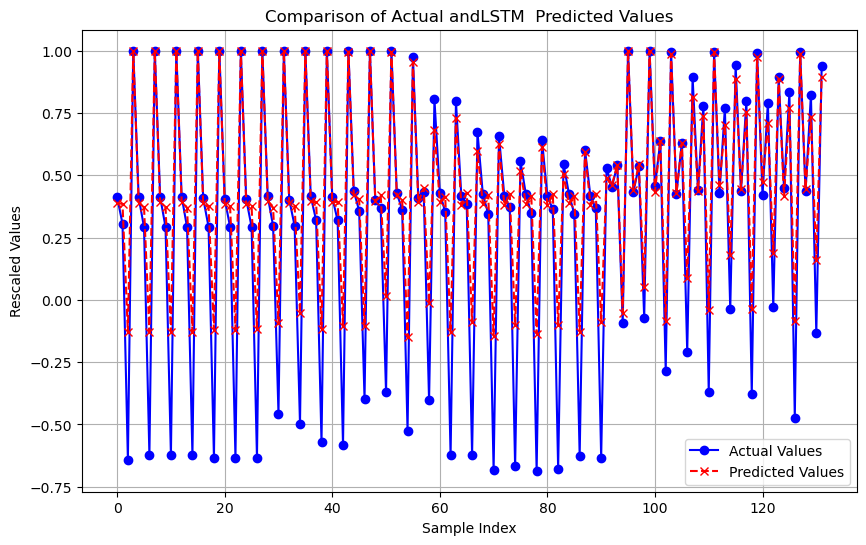

Mean Squared Error (MSE): 0.044127807737781244
Mean Absolute Error (MAE): 0.12482222470260318
R-squared (R²): 0.8369763648546873


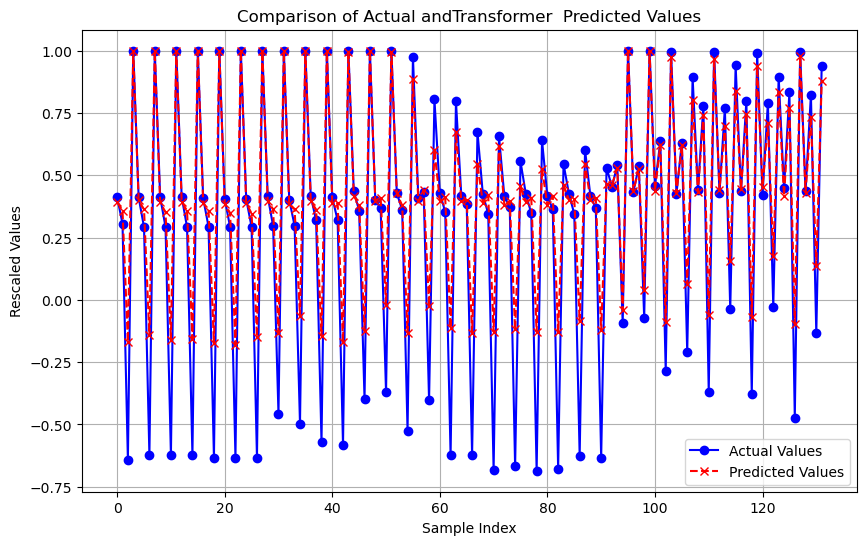

Data saved to Combined_Straight_Drive_human_posture_points.csv


In [ ]:
# List of column names for each of the 33 body points with 4 values each
column_names = [
    'Nose_x', 'Nose_y', 'Nose_z', 'Nose_vis',
    'LEyeInner_x', 'LEyeInner_y', 'LEyeInner_z', 'LEyeInner_vis', 'LEye_x', 'LEye_y', 'LEye_z', 'LEye_vis', 'LEyeOuter_x', 'LEyeOuter_y', 'LEyeOuter_z', 'LEyeOuter_vis', 'REyeInner_x', 'REyeInner_y', 'REyeInner_z', 'REyeInner_vis', 'REye_x', 'REye_y', 'REye_z', 'REye_vis', 'REyeOuter_x', 'REyeOuter_y', 'REyeOuter_z', 'REyeOuter_vis',
    'LEar_x', 'LEar_y', 'LEar_z', 'LEar_vis', 'REar_x', 'REar_y', 'REar_z', 'REar_vis',
    'LShoulder_x', 'LShoulder_y', 'LShoulder_z', 'LShoulder_vis', 'RShoulder_x', 'RShoulder_y', 'RShoulder_z', 'RShoulder_vis',
    'LElbow_x', 'LElbow_y', 'LElbow_z', 'LElbow_vis', 'RElbow_x', 'RElbow_y', 'RElbow_z', 'RElbow_vis', 'LWrist_x', 'LWrist_y', 'LWrist_z', 'LWrist_vis',  'RWrist_x', 'RWrist_y', 'RWrist_z', 'RWrist_vis',
    'LHip_x', 'LHip_y', 'LHip_z', 'LHip_vis',   'RHip_x', 'RHip_y', 'RHip_z', 'RHip_vis',
    'LKnee_x', 'LKnee_y', 'LKnee_z', 'LKnee_vis',  'RKnee_x', 'RKnee_y', 'RKnee_z', 'RKnee_vis', 'LAnkle_x', 'LAnkle_y', 'LAnkle_z', 'LAnkle_vis', 'RAnkle_x', 'RAnkle_y', 'RAnkle_z', 'RAnkle_vis',
    'LFootIdx_x', 'LFootIdx_y', 'LFootIdx_z', 'LFootIdx_vis', 'RFootIdx_x', 'RFootIdx_y', 'RFootIdx_z', 'RFootIdx_vis', 'MidHip_x', 'MidHip_y', 'MidHip_z', 'MidHip_vis', 'Spine_x', 'Spine_y', 'Spine_z', 'Spine_vis',
    'LHeel_x', 'LHeel_y', 'LHeel_z', 'LHeel_vis', 'RHeel_x', 'RHeel_y', 'RHeel_z', 'RHeel_vis', 'LBigToe_x', 'LBigToe_y', 'LBigToe_z', 'LBigToe_vis', 'RBigToe_x', 'RBigToe_y', 'RBigToe_z', 'RBigToe_vis', 'LSmallToe_x', 'LSmallToe_y', 'LSmallToe_z', 'LSmallToe_vis', 'RSmallToe_x', 'RSmallToe_y', 'RSmallToe_z', 'RSmallToe_vis',
    'Chest_x', 'Chest_y', 'Chest_z', 'Chest_vis', 'Neck_x', 'Neck_y', 'Neck_z', 'Neck_vis'
]



predictions_rescaled=next_frame_lstm_rescaled
lstm_rescaled=predictions_rescaled
y_test_rescaled = scaler.inverse_transform(lstm_y_test)

# Print predicted vs actual frames for comparison
#print("Predicted frames by LSTM :")
#print(predictions_rescaled)
#print("Actual frames:")
#print(y_test_rescaled)

pred_actual_frame(pd,Posdataset, lstm_rescaled, y_test_rescaled, "LSTM")

predictions_rescaled=next_frame_transformer_rescaled
transformer_rescaled=predictions_rescaled
y_test_rescaled = scaler.inverse_transform(transformer_y_test)
# Print predicted vs actual frames for comparison
#print("Predicted frames by Transformer:")
#print(predictions_rescaled)
#print("Actual frames:")
#print(y_test_rescaled)
pred_actual_frame(pd, Posdataset, transformer_rescaled, y_test_rescaled, "Transformer")

import pandas as pd
import numpy as np


# Create DataFrames for each type and add a new column for the frame type
# LSTM predictions
df_lstm = pd.DataFrame(lstm_rescaled, columns=column_names)
df_lstm['Frame'] = 'lstm'
df_lstm['Stroke'] = stroke
# Actual values
df_actual = pd.DataFrame(y_test_rescaled, columns=column_names)
df_actual['Frame'] = 'actual'
df_actual['Stroke'] = stroke
# Transformer predictions
df_transformer = pd.DataFrame(transformer_rescaled, columns=column_names)
df_transformer['Frame'] = 'transformer'
df_transformer['Stroke'] = stroke
# Concatenate all DataFrames
df_combined = pd.concat([df_actual, df_lstm, df_transformer], ignore_index=True)

# Save the combined DataFrame to a single CSV file

df_combined.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


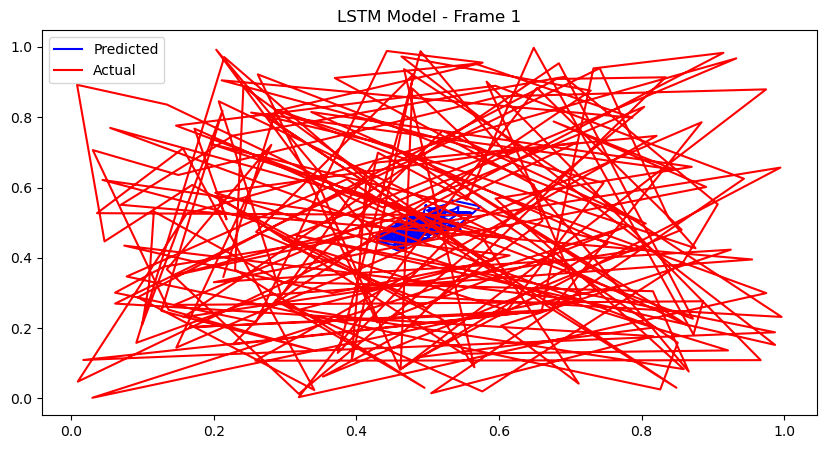

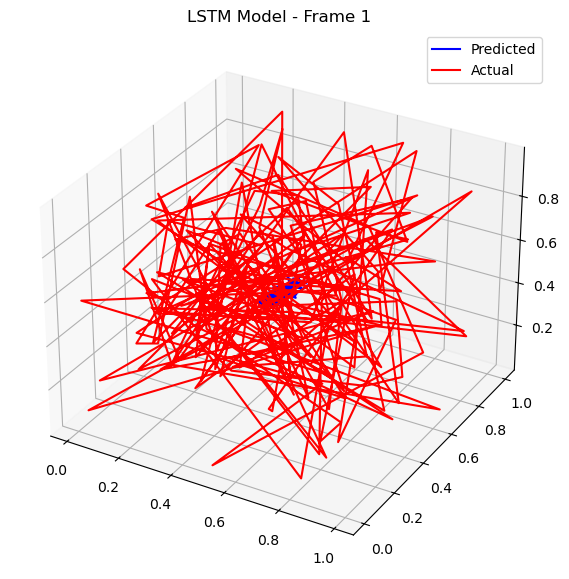

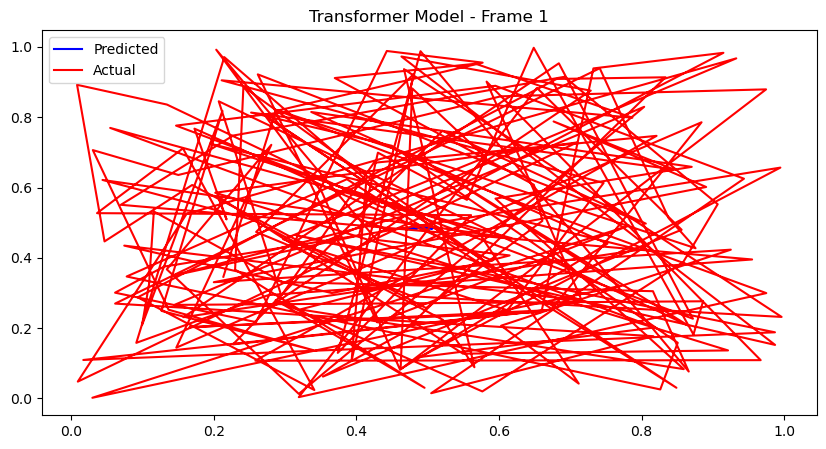

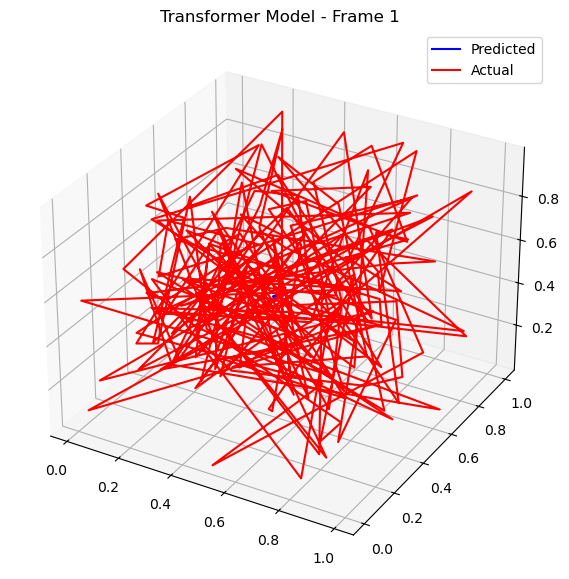

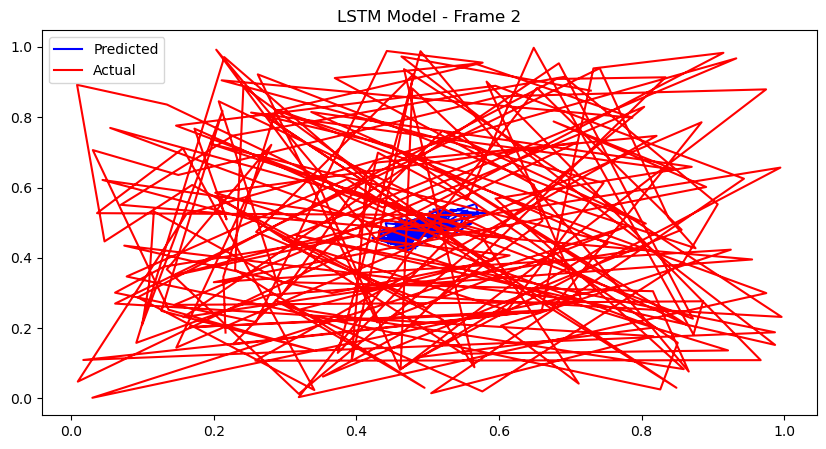

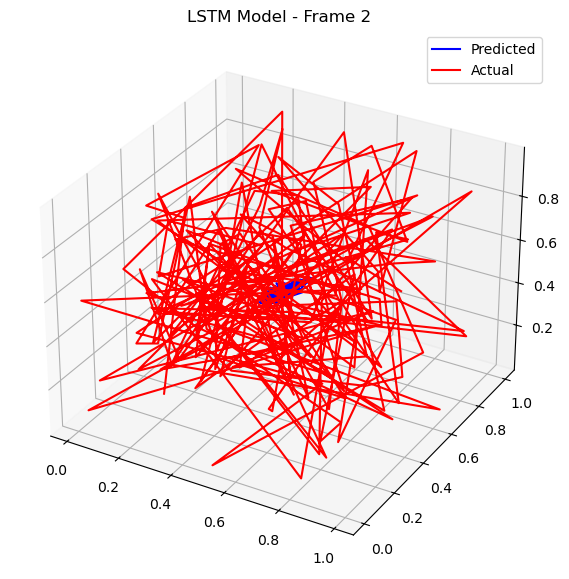

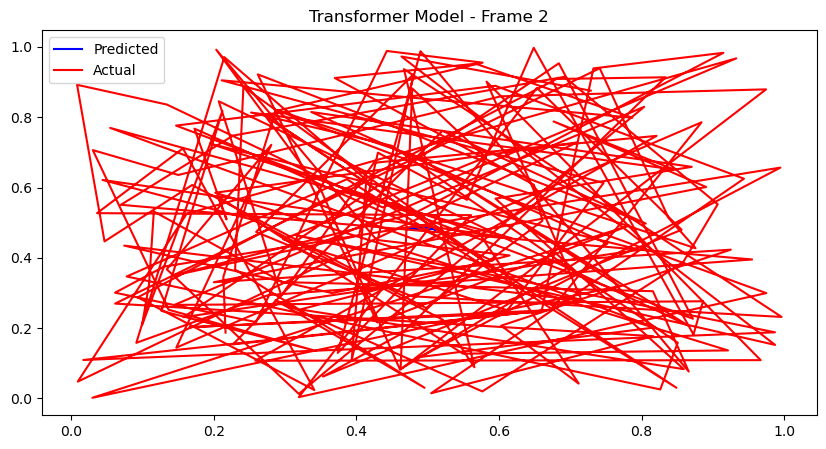

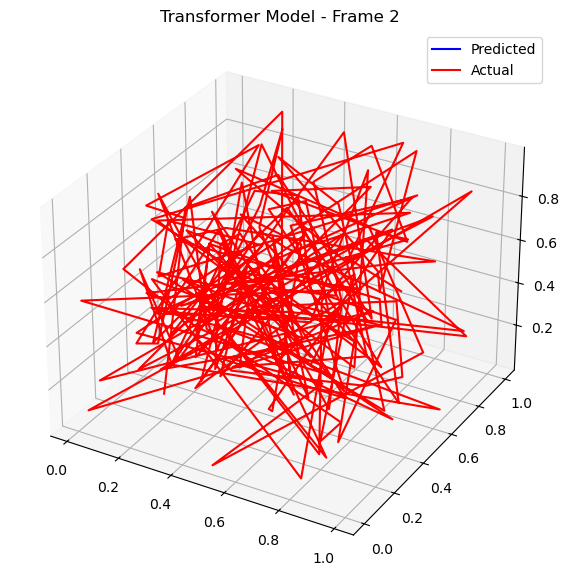

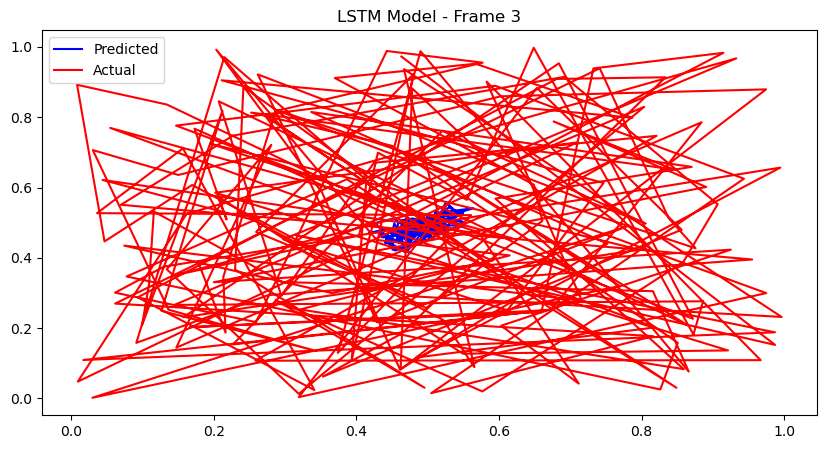

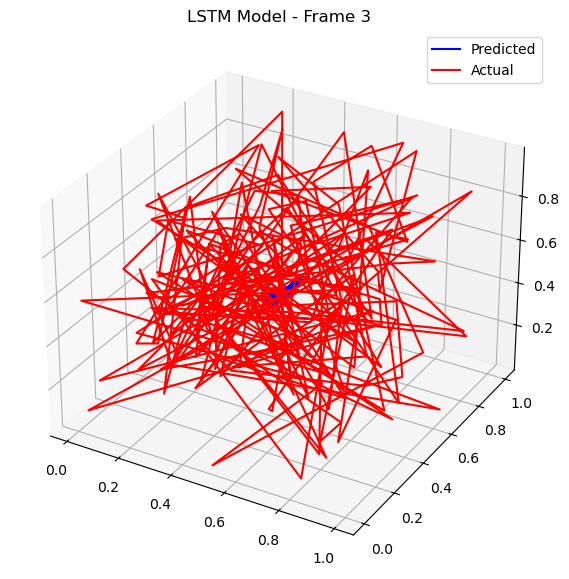

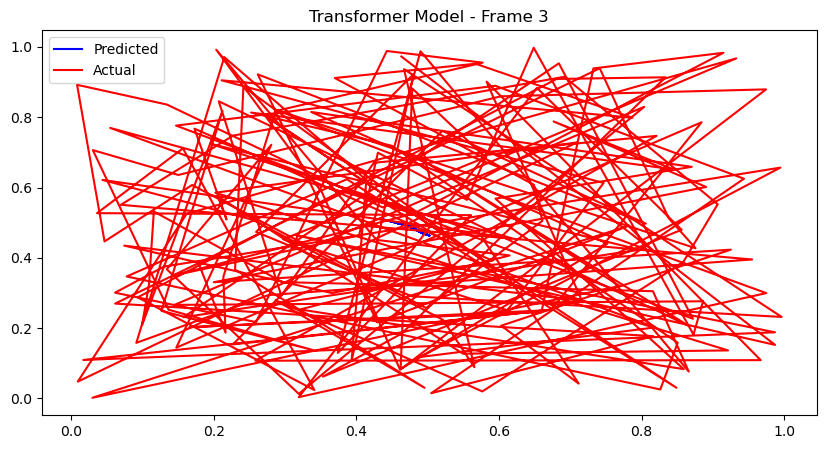

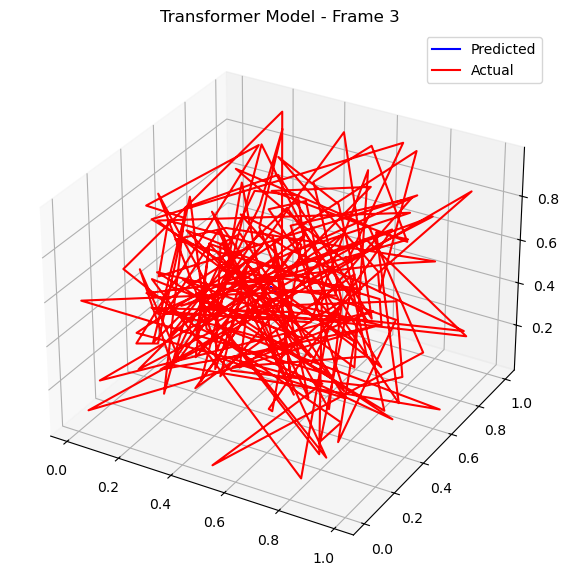

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
# Optimized LSTM Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Visualize 2D plot
def visualize_2d(predictions, y_test, title):
    plt.figure(figsize=(10, 5))
    plt.plot(predictions[:, 0], predictions[:, 1], label='Predicted', color='blue')
    plt.plot(y_test[:, 0], y_test[:, 1], label='Actual', color='red')
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize 3D plot
def visualize_3d(predictions, y_test, title):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2], label='Predicted', color='blue')
    ax.plot(y_test[:, 0], y_test[:, 1], y_test[:, 2], label='Actual', color='red')
    ax.set_title(title)
    plt.legend()
    plt.show()

# Modify the create_sequences function to predict the next 3 frames
def create_sequences(data, timesteps, output_steps=3):
    X, y = [], []
    for i in range(len(data) - timesteps - output_steps + 1):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps:i + timesteps + output_steps].flatten())
    return np.array(X), np.array(y)

# Create train and test data (Replace with your actual data)
data = np.random.rand(1000, 3)  # Sample data with 1000 time steps and 3 features

# Data scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split into training and testing data
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Hyperparameters
timesteps = 10  # Input sequence length
output_steps = 3  # Number of frames to predict
n_features = data.shape[1]  # Number of features
n_outputs = output_steps * n_features  # For predicting 3 frames

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, timesteps, output_steps=output_steps)
X_test, y_test = create_sequences(test_data, timesteps, output_steps=output_steps)


# Optimized LSTM Model for Predicting 3 Frames
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dropout(0.3))  # Increased dropout for regularization
    # Output layer to predict 3 frames (3 * n_features)
    model.add(Dense(3 * n_features, kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Add L2 regularization
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # Tuned learning rate
    return model


# Function to create and train Transformer model

def build_transformer_model():
    input_layer = Input(shape=(timesteps, n_features))

    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=8, key_dim=n_features)(input_layer, input_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Transformer layers with Dense and Dropout
    transformer_output = Dense(64, activation='relu')(attention_output)
    transformer_output = Dropout(0.2)(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Output layer to predict the next 3 frames (n_features * 3)
    output = Dense(n_features * 3)(pooled_output)

    # Build and compile the model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


# Evaluate the model for multiple-frame prediction
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    predictions_reshaped = predictions.reshape(predictions.shape[0], output_steps, n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], output_steps, n_features)

    predictions_rescaled = scaler.inverse_transform(predictions_reshaped.reshape(-1, n_features)).reshape(predictions_reshaped.shape)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped.reshape(-1, n_features)).reshape(y_test_reshaped.shape)

    mse = mean_squared_error(y_test_rescaled.flatten(), predictions_rescaled.flatten())
    mae = mean_absolute_error(y_test_rescaled.flatten(), predictions_rescaled.flatten())

    return mse, mae, predictions_rescaled, y_test_rescaled

# Train and evaluate LSTM model
lstm_model = build_lstm_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Train and evaluate Transformer model
transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
transformer_mse, transformer_mae, transformer_predictions, transformer_y_test = evaluate_model(transformer_model, X_test, y_test)

# Visualize LSTM model predictions for the 1st frame in 2D and 3D
visualize_2d(lstm_predictions[:, 0, :], lstm_y_test[:, 0, :], 'LSTM Model - Frame 1')
visualize_3d(lstm_predictions[:, 0, :], lstm_y_test[:, 0, :], 'LSTM Model - Frame 1')

# Visualize Transformer model predictions for the 1st frame in 2D and 3D
visualize_2d(transformer_predictions[:, 0, :], transformer_y_test[:, 0, :], 'Transformer Model - Frame 1')
visualize_3d(transformer_predictions[:, 0, :], transformer_y_test[:, 0, :], 'Transformer Model - Frame 1')

# Optionally, visualize the 2nd and 3rd predicted frames (LSTM or Transformer)
visualize_2d(lstm_predictions[:, 1, :], lstm_y_test[:, 1, :], 'LSTM Model - Frame 2')
visualize_3d(lstm_predictions[:, 1, :], lstm_y_test[:, 1, :], 'LSTM Model - Frame 2')

visualize_2d(transformer_predictions[:, 1, :], transformer_y_test[:, 1, :], 'Transformer Model - Frame 2')
visualize_3d(transformer_predictions[:, 1, :], transformer_y_test[:, 1, :], 'Transformer Model - Frame 2')

visualize_2d(lstm_predictions[:, 2, :], lstm_y_test[:, 2, :], 'LSTM Model - Frame 3')
visualize_3d(lstm_predictions[:, 2, :], lstm_y_test[:, 2, :], 'LSTM Model - Frame 3')

visualize_2d(transformer_predictions[:, 2, :], transformer_y_test[:, 2, :], 'Transformer Model - Frame 3')
visualize_3d(transformer_predictions[:, 2, :], transformer_y_test[:, 2, :], 'Transformer Model - Frame 3')


In [ ]:
# Print predicted vs actual frames for comparison
print("Predicted frames:")
print(predictions_rescaled)
print("Actual frames:")
print(y_test_rescaled)

In [ ]:

import cv2
import pandas as pd
import numpy as np

# Select only the columns that contain x, y, and z coordinates
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]
original_xyz = OrignalFrame[xyz_columns]

# Define connections between keypoints to draw the skeleton based on F1 to F32
connections = [
    (0, 1), (1, 2), (2, 3),  # Left eye connections
    (0, 4), (4, 5), (5, 6),  # Right eye connections
    (0, 7), (0, 8),  # Nose to ears
    (9, 10),  # Mouth connection
    (11, 12),  # Shoulders
    (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
    (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
    (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
    (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
    (23, 24),  # Hips
    (11, 23), (12, 24),  # Shoulders to hips
    (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
    (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
]

# Create a blank image (adjust size according to your coordinates)
width, height = 640, 480  # Adjust size as needed

# Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
for index in range(len(predicted_xyz)):
    # Clear the image for each frame
    blank_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Extract (x, y) coordinates from the predicted row
    predicted_row = predicted_xyz.iloc[index]
    predicted_keypoints = []
    for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
        y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
        predicted_keypoints.append((int(x), int(y)))

    # Extract (x, y) coordinates from the original row
    original_row = original_xyz.iloc[index]
    original_keypoints = []
    for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = original_row[i] * width  # Assuming x is normalized, scale to image width
        y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
        original_keypoints.append((int(x), int(y)))

    # Draw circles at each keypoint for the predicted frame (color: green)
    for (x, y) in predicted_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 255, 0), cv2.FILLED)

    # Draw lines to form the skeleton for the predicted frame (color: blue)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
            cv2.line(blank_image, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

    # Draw circles at each keypoint for the original frame (color: red)
    for (x, y) in original_keypoints:
        cv2.circle(blank_image, (x, y), 5, (0, 0, 255), cv2.FILLED)

    # Draw lines to form the skeleton for the original frame (color: yellow)
    for connection in connections:
        point1 = connection[0]
        point2 = connection[1]
        if point1 < len(original_keypoints) and point2 < len(original_keypoints):
            cv2.line(blank_image, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

    # Add text to indicate which color represents original and predicted
    cv2.putText(blank_image, 'Original: Pose Red', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image, 'Predicted: Pose Green', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    #cv2.putText(blank_image, 'Original: Shot ' + str(Org_label[0]), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    #cv2.putText(blank_image, 'Predicted: Shot ' + str(pred_label[0]), (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show the skeleton for this frame
    cv2.imshow('Skeleton Comparison', blank_image)

    key = cv2.waitKey(50000) & 0xFF  # Adjust wait time to 30 milliseconds
    if key == ord('q'):
        print("Exiting on 'q' key press")
        break

# Release resources
cv2.destroyAllWindows()

import cv2
import pandas as pd
import numpy as np

# Select only the columns that contain x, y, and z coordinates
xyz_columns = [col for col in PredictedFrame.columns if '_x' in col or '_y' in col or '_z' in col]
predicted_xyz = PredictedFrame[xyz_columns]
original_xyz = OrignalFrame[xyz_columns]

# Define connections between keypoints to draw the skeleton based on F1 to F32
connections = [
    (0, 1), (1, 2), (2, 3),  # Left eye connections
    (0, 4), (4, 5), (5, 6),  # Right eye connections
    (0, 7), (0, 8),  # Nose to ears
    (9, 10),  # Mouth connection
    (11, 12),  # Shoulders
    (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
    (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
    (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
    (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
    (23, 24),  # Hips
    (11, 23), (12, 24),  # Shoulders to hips
    (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
    (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
]

# Create a blank image (adjust size according to your coordinates)
width, height = 640, 480  # Adjust size as needed

# Loop through each row (frame) in the DataFrame to draw the skeleton for each frame
for index in range(len(predicted_xyz)):
    # Clear images for each frame
    blank_image_predicted = np.zeros((height, width, 3), dtype=np.uint8)
    blank_image_original = np.zeros((height, width, 3), dtype=np.uint8)

    # Extract (x, y) coordinates from the predicted row
    predicted_row = predicted_xyz.iloc[index]
    predicted_keypoints = []
    for i in range(0, len(predicted_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = predicted_row[i] * width  # Assuming x is normalized, scale to image width
        y = predicted_row[i + 1] * height  # Assuming y is normalized, scale to image height
        predicted_keypoints.append((int(x), int(y)))

    # Extract (x, y) coordinates from the original row
    original_row = original_xyz.iloc[index]
    original_keypoints = []
    for i in range(0, len(original_row), 3):  # Skip every 3rd value because of the x, y, z format
        x = original_row[i] * width  # Assuming x is normalized, scale to image width
        y = original_row[i + 1] * height  # Assuming y is normalized, scale to image height
        original_keypoints.append((int(x), int(y)))

    # Draw circles and lines for the predicted frame (color: green)
    for (x, y) in predicted_keypoints:
        cv2.circle(blank_image_predicted, (x, y), 5, (0, 255, 0), cv2.FILLED)
    for connection in connections:
        point1, point2 = connection
        if point1 < len(predicted_keypoints) and point2 < len(predicted_keypoints):
            cv2.line(blank_image_predicted, predicted_keypoints[point1], predicted_keypoints[point2], (0, 255, 0), 2)

    # Draw circles and lines for the original frame (color: red)
    for (x, y) in original_keypoints:
        cv2.circle(blank_image_original, (x, y), 5, (0, 0, 255), cv2.FILLED)
    for connection in connections:
        point1, point2 = connection
        if point1 < len(original_keypoints) and point2 < len(original_keypoints):
            cv2.line(blank_image_original, original_keypoints[point1], original_keypoints[point2], (0, 0, 255), 2)

    # Add text for frame labels
    cv2.putText(blank_image_original, 'Original', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(blank_image_predicted, 'Predicted', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Concatenate the two images side by side
    comparison_image = np.hstack((blank_image_original, blank_image_predicted))

    # Display the side-by-side comparison
    cv2.imshow('Original vs Predicted Posture', comparison_image)

    # Wait for keypress or a delay between frames
    key = cv2.waitKey(50000) & 0xFF  # Adjust the delay as needed
    if key == ord('q'):
        print("Exiting on 'q' key press")
        break

# Release resources
cv2.destroyAllWindows()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, MultiHeadAttention, LayerNormalization, Layer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
Posdataset = pd.read_csv('Cover_Drive.csv')
Posdataset_numeric = Posdataset.drop(columns=['Unnamed: 0', 'Label'], axis=1)

# Parameters
timesteps = 10  # Number of previous frames to use for prediction
n_features = Posdataset_numeric.shape[1]  # Number of features
train_size = len(Posdataset_numeric) - 11  # Train on first frames
test_size = 11  # Test on the next frames

# Split the data into train and test sets
train_data = Posdataset_numeric.iloc[:train_size].values
test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_test, y_test = create_sequences(test_data_scaled, timesteps)

# Reshape y_train and y_test to include the time dimension
y_train = y_train.reshape(y_train.shape[0], n_features)  # Adjusted to 2D
y_test = y_test.reshape(y_test.shape[0], n_features)  # Adjusted to 2D

# Custom layer for global average pooling
class GlobalAveragePooling(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)  # Average over timesteps

# Function to build LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to create and train Transformer model
def build_transformer_model():
    input_layer = Input(shape=(timesteps, n_features))
    attention_output = MultiHeadAttention(num_heads=4, key_dim=n_features)(input_layer, input_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    transformer_output = Dense(64, activation='relu')(attention_output)
    transformer_output = Dropout(0.2)(transformer_output)
    # Use the custom global average pooling layer
    pooled_output = GlobalAveragePooling()(transformer_output)
    output = Dense(n_features)(pooled_output)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Ensure that predictions and y_test are 2D (samples, features)
    predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

    # Inverse transform the predictions and y_test
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

    return mse, mae, predictions_rescaled, y_test_rescaled

# Train and evaluate LSTM
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Output results for LSTM
print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')

# Train and evaluate Transformer
transformer_model = build_transformer_model()
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
transformer_mse, transformer_mae, transformer_predictions, transformer_y_test = evaluate_model(transformer_model, X_test, y_test)

# Output results for Transformer
print(f'Transformer Model MSE: {transformer_mse}, MAE: {transformer_mae}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
LSTM Model MSE: 0.0007213922019645709, MAE: 0.018078314272729188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Transformer Model MSE: 0.0009426665851081053, MAE: 0.021038084728361096


In [ ]:
# Predict the next 5 frames for both models
predicted_frames_lstm = []
predicted_frames_transformer = []

# Initialize the last known input for prediction
last_input = X_test[-1]

for _ in range(5):
    # Reshape the input for both models
    next_frame_lstm = lstm_model.predict(np.reshape(last_input, (1, timesteps, n_features)))
    next_frame_transformer = transformer_model.predict(np.reshape(last_input, (1, timesteps, n_features)))

    # Inverse scale the predictions
    next_frame_lstm_rescaled = scaler.inverse_transform(next_frame_lstm)
    next_frame_transformer_rescaled = scaler.inverse_transform(next_frame_transformer)

    predicted_frames_lstm.append(next_frame_lstm_rescaled)
    predicted_frames_transformer.append(next_frame_transformer_rescaled)

    # Update last_input for the next prediction
    last_input = np.append(last_input[1:], next_frame_lstm, axis=0)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
predicted_frames_lstm

[array([[ 0.39665058,  0.4301525 , -0.12879096,  0.99972993,  0.392309  ,
          0.41931805, -0.12208446,  0.99956435,  0.3988745 ,  0.4158408 ,
         -0.13073474,  0.99933565,  0.3997283 ,  0.418661  , -0.13383533,
          0.99948335,  0.396635  ,  0.42866668, -0.11309059,  0.9993638 ,
          0.39043736,  0.4240384 , -0.11726225,  0.9991678 ,  0.38894457,
          0.42388296, -0.12253381,  0.9996328 ,  0.39215127,  0.4149689 ,
         -0.09367282,  0.99896085,  0.388604  ,  0.43305066, -0.06018421,
          0.99904376,  0.39939028,  0.43298927, -0.11287224,  0.9991746 ,
          0.40240085,  0.4423    , -0.09902638,  0.99894893,  0.4349835 ,
          0.4323356 , -0.09103313,  0.99874604,  0.4039654 ,  0.47400406,
          0.0022147 ,  0.9961736 ,  0.42068622,  0.3798944 , -0.15728155,
          0.9647141 ,  0.39171454,  0.48466903, -0.04943574,  0.8653656 ,
          0.39734668,  0.38682675, -0.16287212,  0.82573265,  0.3739533 ,
          0.43146044, -0.11355498,  0.

In [ ]:
# Convert the predicted frames to a NumPy array for easier indexing
predicted_frames_lstm = np.array(predicted_frames_lstm).squeeze()
predicted_frames_transformer = np.array(predicted_frames_transformer).squeeze()

# Prepare for visualization
# Assume you have the original frames as well, which should be the next frames in your test dataset
original_frames = y_test[-5:]  # Get the last 5 actual frames from the test set


Visualizing predictions for LSTM model...


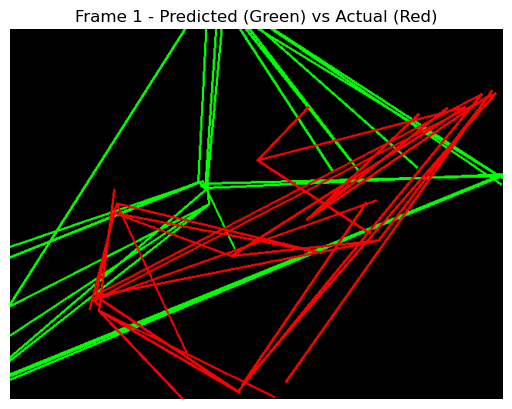

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
# Create a comparison visualization
def visualize_predictions(predicted_frames, original_frames):
    # Define connections between keypoints to draw the skeleton
    connections = [
        (0, 1), (1, 2), (2, 3),  # Left eye connections
        (0, 4), (4, 5), (5, 6),  # Right eye connections
        (0, 7), (0, 8),  # Nose to ears
        (9, 10),  # Mouth connection
        (11, 12),  # Shoulders
        (11, 13), (13, 15),  # Left arm (shoulder, elbow, wrist)
        (15, 17), (15, 19), (15, 21),  # Left hand (wrist to pinky, index, thumb)
        (12, 14), (14, 16),  # Right arm (shoulder, elbow, wrist)
        (16, 18), (16, 20), (16, 22),  # Right hand (wrist to pinky, index, thumb)
        (23, 24),  # Hips
        (11, 23), (12, 24),  # Shoulders to hips
        (23, 25), (25, 27), (27, 29), (27, 31),  # Left leg (hip, knee, ankle, heel, foot index)
        (24, 26), (26, 28), (28, 30), (28, 32),  # Right leg (hip, knee, ankle, heel, foot index)
    ]

    # Create a blank image for visualization
    width, height = 640, 480  # Adjust size as needed

    # Loop through each predicted and actual frame to draw the skeleton
    for i in range(len(predicted_frames)):
        # Create a blank image for the current frame
        blank_image = np.zeros((height, width, 3), dtype=np.uint8)

        # Extract (x, y) coordinates from the predicted frame
        predicted_keypoints = []
        for j in range(0, len(predicted_frames[i]), 3):  # Skip every 3rd value (x, y, z)
            x = predicted_frames[i][j] * width  # Scale to image width
            y = predicted_frames[i][j + 1] * height  # Scale to image height
            predicted_keypoints.append((int(x), int(y)))

        # Extract (x, y) coordinates from the original frame
        original_keypoints = []
        for j in range(0, len(original_frames[i]), 3):  # Skip every 3rd value (x, y, z)
            x = original_frames[i][j] * width  # Scale to image width
            y = original_frames[i][j + 1] * height  # Scale to image height
            original_keypoints.append((int(x), int(y)))

        # Draw the skeleton for the predicted frame
        for connection in connections:
            start, end = connection
            if start < len(predicted_keypoints) and end < len(predicted_keypoints):
                cv2.line(blank_image, predicted_keypoints[start], predicted_keypoints[end], (0, 255, 0), 2)

        # Draw the skeleton for the original frame
        for connection in connections:
            start, end = connection
            if start < len(original_keypoints) and end < len(original_keypoints):
                cv2.line(blank_image, original_keypoints[start], original_keypoints[end], (0, 0, 255), 2)

        # Display the image
        plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Frame {i + 1} - Predicted (Green) vs Actual (Red)')
        plt.axis('off')
        plt.show()

# Visualize predictions for both models
print("Visualizing predictions for LSTM model...")
visualize_predictions(predicted_frames_lstm, original_frames)
print("Visualizing predictions for Transformer model...")
visualize_predictions(predicted_frames_transformer, original_frames)


LSTM Working model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load your datasets
Posdataset = pd.read_csv('Cover_Drive.csv')
Posdataset_numeric = Posdataset.drop(columns=['Unnamed: 0', 'Label'], axis=1)

# Parameters
timesteps = 10  # Number of previous frames to use for prediction
n_features = Posdataset_numeric.shape[1]  # Number of features
train_size = len(Posdataset_numeric) - 11  # Train on first frames
test_size = 11  # Test on the next frames

# Split the data into train and test sets
train_data = Posdataset_numeric.iloc[:train_size].values
test_data = Posdataset_numeric.iloc[train_size:train_size + test_size].values

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Create sequences
X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_test, y_test = create_sequences(test_data_scaled, timesteps)

# Reshape y_train and y_test to include the time dimension
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

# Function to build LSTM model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Ensure that predictions and y_test are 2D (samples, features)
    predictions_reshaped = predictions.reshape(predictions.shape[0], n_features)
    y_test_reshaped = y_test.reshape(y_test.shape[0], n_features)

    # Inverse transform the predictions and y_test
    predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

    return mse, mae, predictions_rescaled, y_test_rescaled

# Train and evaluate LSTM
lstm_model = build_lstm_model()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
lstm_mse, lstm_mae, lstm_predictions, lstm_y_test = evaluate_model(lstm_model, X_test, y_test)

# Output results
print(f'LSTM Model MSE: {lstm_mse}, MAE: {lstm_mae}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
LSTM Model MSE: 0.01170026497639083, MAE: 0.0704915001423973
